# 마스크를 detection 하기 위한 VGG19 모델

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Input, GlobalMaxPool2D
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
drive.mount('/content/drive')

#google drive에 저장되어 있는 파일을 이용해 colab으로 학습.

Mounted at /content/drive


In [ ]:
# 데이터 로드

data_path = '/content/drive/MyDrive/colab/mask detection/'

#폴더별로 이미 잘 정리 되어 있어 csv 파일은 필요 없음.
train_set = pd.read_csv(data_path + 'Train.csv')
validation_set = pd.read_csv(data_path + 'Validation.csv')
test_set = pd.read_csv(data_path + 'Test.csv')

train_set.head()

,Image_id,With_mask
0,Train1.jpg,1
1,Train10.jpg,1
2,Train100.jpg,1
3,Train1000.jpg,1
4,Train1001.jpg,1


In [ ]:
# import PIL
# from pathlib import Path
# from PIL import UnidentifiedImageError

# path = Path('/content/drive/MyDrive/colab/mask detection/Test').rglob("*.jpg")
# for img_p in path:
#     try:
#         img = PIL.Image.open(img_p)
#     except PIL.UnidentifiedImageError:
#             print(img_p)

# 에러가 발생했는데 이미지를 불러 올 수가 없어서 탐지함. validation 800 파일이 문제가 생겨 그것을 삭제함. 

In [ ]:
# 각 폴더 별 경로 설정
TRAIN_DIR = data_path+'Train/'
VALID_DIR = data_path+'Validation/'
TEST_DIR = data_path+'Test/'

In [ ]:
# vgg 19 모델 설정

from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.applications import VGG19
from keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau

base_model  = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False
model = keras.Sequential(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2, activation='softmax'))
optimizerAdam = Adam(learning_rate=0.00001, amsgrad=True)
model.compile(optimizer=optimizerAdam, loss = 'categorical_crossentropy',  metrics=['accuracy'])
model.summary()
print("freeze 후 훈련되는 가중치 수 : " , len(model.trainable_weights))

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              patience=5)  
                          
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = data_path + 'best_model.h5',       
                             monitor='val_loss',  
                             verbose=1,           
                             save_best_only=True,  
                             mode='min')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 45,721,666
Trainable params: 25,695,234
Non-trainable params: 20,026,432
___________________________________

In [ ]:
# 데이터 증식

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

img_height = 224
img_width = 224
batch_size = 64
epochs = 30

labels = ['With_mask', 'Without_mask']

training_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range=30, #무작위 회전각도 30도 이내
                                      width_shift_range=0.2, #지정된 수평방향 이동 범위내에서 임의로 원본이미지를 20% 내외로 이동
                                      height_shift_range=0.2, #지정된 수직방향 이동 범위내에서 임의로 원본이미지를 20% 내외로 이동
                                      shear_range=0.2, #층밀리기 강도 20% 
                                      zoom_range=0.2, #무작위 줌 범위 20%
                                      horizontal_flip=True, #무작위로 가로로 뒤짚기
                                      fill_mode='nearest' #이미지에 여백이생겼을때 가장 가까운 픽셀을 찾아 채우는 방법
                                      )

validation_datagen =  ImageDataGenerator(rescale = 1./255,
                                      rotation_range=30,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest'
                                      )

test_dataGenerator = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(TRAIN_DIR, target_size=(img_height,img_width), class_mode='categorical', color_mode='rgb', batch_size=batch_size, shuffle=True)
train_generator2 = training_datagen.flow_from_directory(TRAIN_DIR, target_size=(img_height,img_width), class_mode='categorical', color_mode='rgb', batch_size=batch_size, shuffle=False)
validation_generator = validation_datagen.flow_from_directory(VALID_DIR, target_size=(img_height,img_width), class_mode='categorical', color_mode='rgb', batch_size=batch_size, shuffle=True)
validation_generator2 = validation_datagen.flow_from_directory(VALID_DIR, target_size=(img_height,img_width), class_mode='categorical', color_mode='rgb', batch_size=batch_size, shuffle=False)
test_generator = validation_datagen.flow_from_directory(TEST_DIR, target_size=(img_height,img_width), class_mode='categorical', color_mode='rgb', batch_size=batch_size, shuffle=True)
test_generator2 = validation_datagen.flow_from_directory(TEST_DIR, target_size=(img_height,img_width), class_mode='categorical', color_mode='rgb', batch_size=batch_size, shuffle=False) 

#각 generator마다 2가 존재하는 이유는
#Keras predict_generator로 confusion matrix를 그렸을 때 accuracy가 안 맞는 오류 때문에 생성
#실제로 해보니 shuffle 하기 전 validation의 label과 shuffle 후 validation predict를 비교하는 것을 확인할 수 있었음.

Found 10003 images belonging to 2 classes.
Found 10003 images belonging to 2 classes.
Found 799 images belonging to 2 classes.
Found 799 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data=validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      epochs=10)

Epoch 1/10
156/156 [==============================] - 3025s 19s/step - loss: 0.2104 - accuracy: 0.9130 - val_loss: 0.1766 - val_accuracy: 0.9570
Epoch 2/10
156/156 [==============================] - 122s 782ms/step - loss: 0.1086 - accuracy: 0.9605 - val_loss: 0.1128 - val_accuracy: 0.9609
Epoch 3/10
156/156 [==============================] - 122s 780ms/step - loss: 0.0885 - accuracy: 0.9691 - val_loss: 0.0805 - val_accuracy: 0.9740
Epoch 4/10
156/156 [==============================] - 122s 781ms/step - loss: 0.0855 - accuracy: 0.9691 - val_loss: 0.0756 - val_accuracy: 0.9753
Epoch 5/10
156/156 [==============================] - 123s 790ms/step - loss: 0.0744 - accuracy: 0.9717 - val_loss: 0.0767 - val_accuracy: 0.9688
Epoch 6/10
156/156 [==============================] - 122s 785ms/step - loss: 0.0681 - accuracy: 0.9749 - val_loss: 0.1067 - val_accuracy: 0.9596
Epoch 7/10
156/156 [==============================] - 123s 786ms/step - loss: 0.0633 - accuracy: 0.9769 - val_loss: 0.0710 - 

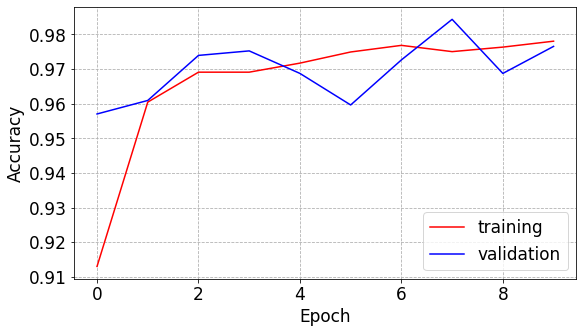

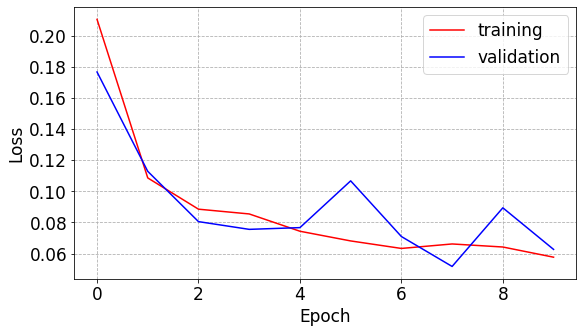

In [ ]:
fs = 17
fig = plt.figure(figsize=(9,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.ylabel('Accuracy',fontsize=fs)
plt.xlabel('Epoch',fontsize=fs)
plt.legend(['training', 'validation'],fontsize=fs)
plt.grid('both', linestyle='--')
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.show()

fig = plt.figure(figsize=(9,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.ylabel('Loss',fontsize=fs)
plt.xlabel('Epoch',fontsize=fs)
plt.legend(['training', 'validation'],fontsize=fs)
plt.grid('both', linestyle='--')
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.show()

In [ ]:
base_model.trainable = True
model.compile(optimizer=optimizerAdam, loss = 'binary_crossentropy',  metrics=['accuracy'])
model.summary()
print("unfreeze 후 훈련되는 가중치 수 : " , len(model.trainable_weights))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 45,721,666
Trainable params: 45,719,618
Non-trainable params: 2,048
________________________________________

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data=validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      epochs=epochs,
      callbacks = [earlystopping, checkpoint]
      )

Epoch 1/30
156/156 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9844
Epoch 00001: val_loss improved from inf to 0.01243, saving model to /content/drive/MyDrive/colab/mask detection/best_model.h5
156/156 [==============================] - 133s 829ms/step - loss: 0.0429 - accuracy: 0.9844 - val_loss: 0.0124 - val_accuracy: 0.9961
Epoch 2/30
156/156 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9946
Epoch 00002: val_loss improved from 0.01243 to 0.00360, saving model to /content/drive/MyDrive/colab/mask detection/best_model.h5
156/156 [==============================] - 139s 887ms/step - loss: 0.0156 - accuracy: 0.9946 - val_loss: 0.0036 - val_accuracy: 0.9987
Epoch 3/30
156/156 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9982
Epoch 00003: val_loss did not improve from 0.00360
156/156 [==============================] - 129s 821ms/step - loss: 0.0073 - accuracy: 0.9982 - val_loss: 0.0059 - val_accuracy: 0.9987


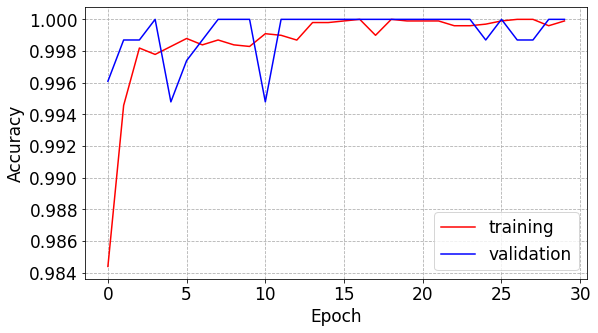

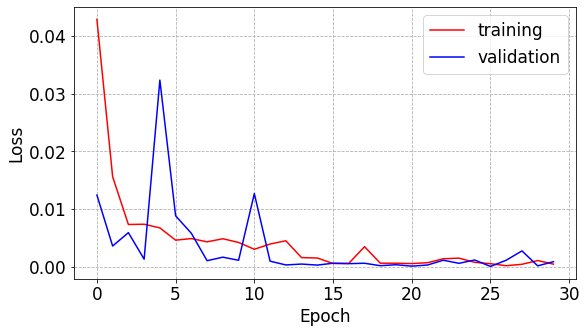

In [ ]:
fs = 17
fig = plt.figure(figsize=(9,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.ylabel('Accuracy',fontsize=fs)
plt.xlabel('Epoch',fontsize=fs)
plt.legend(['training', 'validation'],fontsize=fs)
plt.grid('both', linestyle='--')
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.show()

fig = plt.figure(figsize=(9,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.ylabel('Loss',fontsize=fs)
plt.xlabel('Epoch',fontsize=fs)
plt.legend(['training', 'validation'],fontsize=fs)
plt.grid('both', linestyle='--')
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.show()

In [ ]:
keras_model_best = keras.models.load_model(data_path + 'best_model.h5') # early stopping 된 모델 로드

In [ ]:
Y_pred = keras_model_best.predict(validation_generator2, validation_generator2.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator2.classes, y_pred))
target_names = ['With_mask', 'Without_mask']

Confusion Matrix
[[400   0]
 [  1 398]]


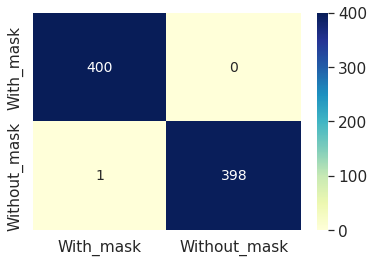

In [ ]:
cm = confusion_matrix(validation_generator2.classes,y_pred)
sn.set(font_scale=1.4)
sn.heatmap(cm, annot=True, annot_kws={"size": 14}, cmap="YlGnBu", fmt='d',  xticklabels = labels, yticklabels = labels)
plt.show()

In [ ]:
Y_pred = keras_model_best.predict(test_generator2, test_generator2.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator2.classes, y_pred))

Confusion Matrix
[[483   0]
 [  0 509]]


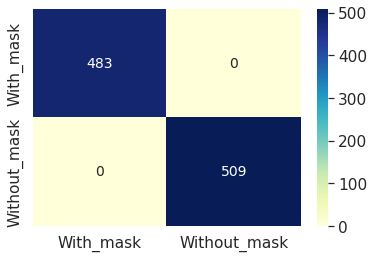

In [ ]:
cm = confusion_matrix( y_pred ,test_generator2.classes)
sn.set(font_scale=1.4)
sn.heatmap(cm, annot=True, annot_kws={"size": 14}, cmap="YlGnBu", fmt='d', xticklabels = labels, yticklabels = labels)
plt.show()